# Code for the figures
This notebook contains scripts for producing figures in the paper and SI.

## Import required libraries 

In [1]:
from scipy.stats import t
from functools import partial
from timeit import default_timer as timer
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
from statistics import mean
from scipy.stats import norm
import pandas as pd
import string
import math
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import elfi
from scipy.integrate import quad
%matplotlib inline

## Global variables for plotting

In [2]:
DATA_FOLDER = 'data/'

SIZELINE = 1.0
AXWIDTH = 0.4
SUBLABEL_SIZE = 10
LABEL_SIZE = 6
FAMILY = 'Arial'
SINGLE_COLUMN = 8.5/2.54
ONE_FIVE_COLUMN = 11.4/2.54
DOUBLE_COLUMN = 17.4/2.54

mpl.rc('lines', linewidth=SIZELINE)
mpl.rc('axes', linewidth=AXWIDTH)
mpl.rc('font', size=LABEL_SIZE*2, family=FAMILY)
mpl.rc(('xtick.major', 'xtick.minor', 'ytick.major', 'ytick.minor'), width=AXWIDTH)

TRUE_MEAN_LABEL = 'True mean, $\mu_t$'
ESTD_MEAN_LABEL = 'Estimated\nmean, $\hat{\mu}$'
TRUE_STD_LABEL = 'True standard\ndeviation, $\sigma_t$'
ESTD_STD_LABEL = 'Estimated standard\ndeviation, $\hat{\sigma}$'
ENCOUNTER_LABEL = 'Target cell encounters'
POA_LABEL = 'Probability of activation'

DASH_STYLE = dict(color='k', linestyle='dashed', alpha=0.5)

# Figure Serial killing exp

[0.997 0.936 0.848 0.766 0.763 0.563]


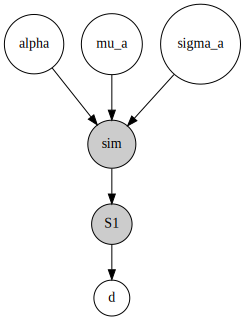

In [3]:
# ELFI simulation
def simulator(alpha, mu_a, sigma_a, batch_size=10, random_state=None):
	alpha   = np.array(alpha).reshape((-1,1))
	mu_a    = np.array(mu_a).reshape((-1,1))
	sigma_a = np.array(sigma_a).reshape((-1,1)) 
	N_nk=1000 # number of cells
	kappa = 2*alpha
	# training
	ms=np.zeros((batch_size,N_nk))
	betas=np.ones((batch_size,N_nk))*alpha
	N_train = 300 # to ensure parameters adapt to new env
	for i in range(N_train):
		xs = np.random.normal(0, 1,size=(batch_size,N_nk)) 
		ms_new = (kappa*ms+xs)/(kappa+1)
		betas = (alpha-1)/(alpha-0.5)*(betas+0.5*kappa/(kappa+1)*(xs-ms)**2)
		ms = ms_new
	# serial killing
	ps = np.zeros((batch_size,6))
	for i_encounter in range(6):
		thresholds = t.ppf(0.99, 2*alpha, ms, np.sqrt((kappa+1)*betas/kappa/alpha))
		xs = np.random.normal(mu_a,sigma_a,size=(batch_size,N_nk))
		response = xs>thresholds
		ps[:,i_encounter] = np.sum(response,axis=1)/N_nk
		ms_new = (kappa*ms+xs)/(kappa+1)
		betas = (alpha-1)/(alpha-0.5)*(betas+0.5*kappa/(kappa+1)*(ms-xs)**2)
		ms = ms_new
	return(ps)
y_exp = np.array([[0.997, 0.936, 0.848, 0.766, 0.763, 0.563]])
n_exp = np.array([347,250,151,77,38,16])
y_exp_array = np.array([0.997, 0.936, 0.848, 0.766, 0.763, 0.563])
y_exp_std = np.sqrt(y_exp_array*(1-y_exp_array))
y_exp_bar = y_exp_std/np.sqrt(n_exp)
print(y_exp_array)

alpha = elfi.Prior('uniform',1,50)
mu_a  = elfi.Prior('gamma', 2, 0, 2)
sigma_a  = elfi.Prior('gamma', 2, 0, 2)
sim = elfi.Simulator(simulator, alpha, mu_a, sigma_a, observed=y_exp)

def feature(x): 
	return(x)

def distance(res_sim,res_obs):
	# relative difference
	d=np.sum(((res_sim-res_obs)/y_exp_bar)**2,axis=1)
	return(d)
S1 = elfi.Summary(feature, sim)
d = elfi.Distance(distance, S1) # d btw summary and observe
elfi.draw(d) 

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Method: Rejection
Number of samples: 500
Number of simulations: 50000
Threshold: 22.2
Sample means: alpha: 23.1, mu_a: 8.42, sigma_a: 2.38


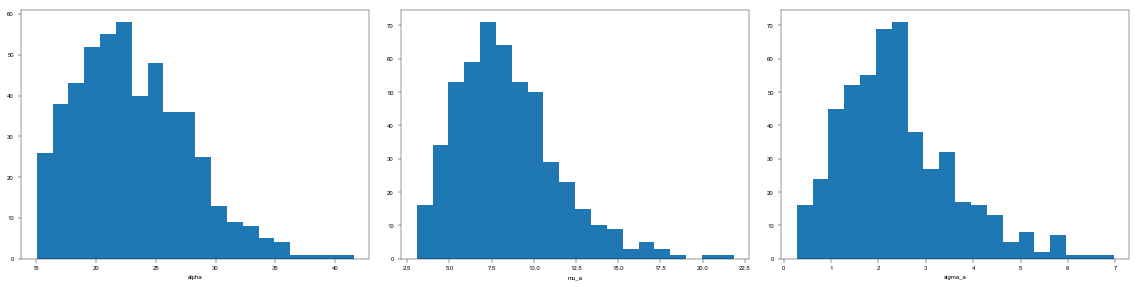

In [9]:
seed = 20210701
rej = elfi.Rejection(d,batch_size=10,seed=seed) 
result = rej.sample(500, quantile=0.01) 
#result = rej.sample(1, threshold=0.014) 
result.summary()
result.plot_marginals();

In [10]:
# save samples selected
data=pd.DataFrame()
data['alpha']   = result.samples['alpha']
data['mu_a']    = result.samples['mu_a']
data['sigma_a']    = result.samples['sigma_a']
print(data.head())
data.to_csv('Fig6parafit.csv')

       alpha       mu_a   sigma_a
0  23.305331   7.776468  2.504417
1  19.114037   8.809879  2.494724
2  22.983936  11.144732  3.598086
3  20.616747  12.756419  4.657118
4  22.341974   8.262727  2.600526


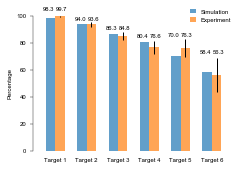

In [17]:
def serial_kill(alpha, mu_a, sigma_a):
	N_nk=1000 # number of cells
	kappa = 2*alpha
	# train
	n_updates=300
	kappa = 2*alpha
	ms=np.zeros(N_nk)
	betas=np.ones(N_nk)*alpha
	for j in range(n_updates):
		xs = np.random.randn(N_nk)
		ms_new = (xs+kappa*ms)/(kappa+1)
		betas = (alpha-1)/(alpha-0.5)*(betas+0.5*kappa/(kappa+1)*(xs-ms)**2)
		ms=ms_new
	p = np.zeros(6)
	for i_encounter in range(6):
		threshold = t.ppf(0.99, 2*alpha, ms, np.sqrt((kappa+1)*betas/kappa/alpha))
		xs = np.random.normal(mu_a,sigma_a,N_nk)
		response = xs>threshold
		p[i_encounter] = np.sum(response)/N_nk
		ms_new = (kappa*ms+xs)/(kappa+1)
		betas = (alpha-1)/(alpha-0.5)*(betas+0.5*kappa/(kappa+1)*(ms-xs)**2)
		ms = ms_new
	return(p)

alpha, mu_a, sigma_a = 23.3, 7.78, 2.50
y = serial_kill(alpha, mu_a, sigma_a)
# convert to percentage
y_percent = y*100
y_exp_percent = y_exp_array*100 
y_exp_bar_percent = y_exp_bar*100 

fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN*0.8))
plt.rc('font', size=LABEL_SIZE, family=FAMILY)
ax = fig.add_axes([0.15, 0.15, 0.8, 0.7])
ax.spines['left'].set_position(('axes', -0.02))
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

bar_width = 0.3
d_bar = 0.15
x = np.array([1,2,3,4,5,6])
ax.bar(x-d_bar,y_percent, width=bar_width, label='Simulation', alpha=0.7)
ax.bar(x+d_bar,y_exp_percent,yerr=y_exp_bar_percent,width=bar_width, label = 'Experiment', alpha=0.7)
y_label = np.array([105,98,91,85,86,73]) # height of text
for index, value in enumerate(y_percent):
	ax.text(index+1-0.21, y_label[index], '%.1f'%value, ha='center', va='center', fontsize=LABEL_SIZE)
for index, value in enumerate(y_exp_percent):
	ax.text(index+1+0.21, y_label[index], '%.1f'%value, ha='center', va='center', fontsize=LABEL_SIZE)
ax.legend(loc='center',bbox_to_anchor=(0.85, 0.75, 0.1, 0.5),handlelength=1, frameon=False)
ax.set_ylabel('Percentage')
ax.set_xticks(x)
ax.tick_params(axis='x',bottom=False,labelbottom=True)
ax.set_xticklabels(['Target 1', 'Target 2', 'Target 3', 'Target 4', 'Target 5', 'Target 6'])

ax.set_ylim(0,100)
plt.show()
fig.savefig('fig6-serialkill.pdf', dpi=300)

# Figure Elliott exp data

[[0.1925     0.06766667]]


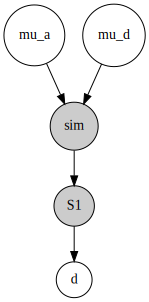

In [3]:
# ELFI simulation
def sim_experiment(mu_env, mu_a, N_nk, batch_size):
	alpha = 20
	kappa = 2*alpha
	ms=np.zeros((batch_size,N_nk))
	betas=np.ones((batch_size,N_nk))*alpha
	N_train = 300 # to ensure parameters adapt to new env
	for i in range(N_train):
		xs = np.random.normal(mu_env, 1,size=(batch_size,N_nk)) 
		# mu_env and 1 .size=betch_size, xs[i,:]~N(mu[i],si[i])
		ms_new = (kappa*ms+xs)/(kappa+1)
		betas = (alpha-1)/(alpha-0.5)*(betas+0.5*kappa/(kappa+1)*(xs-ms)**2)
		ms = ms_new
	N_response = 300 # last as long as the adaption time needed
	response = np.zeros((batch_size,N_response))
	for i in range(N_response):
		xs = np.random.normal(mu_env, 1,size=(batch_size,N_nk))
		ms_new = (kappa*ms+xs)/(kappa+1)
		betas = (alpha-1)/(alpha-0.5)*(betas+0.5*kappa/(kappa+1)*(xs-ms)**2)
		ms = ms_new
		thresholds = t.ppf(0.99, 2*alpha, ms, np.sqrt((kappa+1)*betas/kappa/alpha))
		poas = 1-norm.cdf(thresholds, loc=mu_a, scale=1)
		response[:,i] = np.mean(poas,axis=1) 
	return(response)

def simulator(mu_a, mu_d, batch_size=10, random_state=None):
	'''
	alpha is memory length
	wild type signal N(0,1), 
	MHC-I deficient signal N(mu_d, 1^2),
	aberrant signal distribution N(mu_a,1^2).
	'''
	mu_a = np.array(mu_a).reshape((-1,1))
	mu_d = np.array(mu_d).reshape((-1,1)) 
	# in wild type, trained in wild type signal and calculate response to aberrant signal
	N_nk = 100
	response_w = sim_experiment(np.array([0]).reshape((-1,1)), mu_a,N_nk, batch_size)
	w_mean = np.mean(response_w,axis=1)
	# in MHC dificient type
	response_d = sim_experiment(mu_d, mu_a, N_nk, batch_size)
	d_mean = np.mean(response_d,axis=1)
	res = np.zeros((batch_size,2))
	res[:,0] = w_mean
	res[:,1] = d_mean
	return(res)
exp_w = np.array([19.8, 22.9, 16.8, 20.5, 16.9, 18.6])/100
exp_d = np.array([4.4, 10.6, 5, 6.2, 7.2, 7.2])/100
y_exp = np.array([[np.mean(exp_w), np.mean(exp_d)]])
print(y_exp)


mu_a = elfi.Prior('gamma', 2, 0, 2)
mu_d = elfi.Prior('gamma', 2, 0, 2)

sim = elfi.Simulator(simulator, mu_a, mu_d, observed=y_exp)

def feature(x): 
	return(x)

def distance(res_sim,res_obs):
	# relative diffeerence
	# d=np.sum(((res_sim-res_obs)/res_obs)**2,axis=1)
	d=np.sum((res_sim-res_obs)**2,axis=1)
	return(d)
S1 = elfi.Summary(feature, sim)
d = elfi.Distance(distance, S1) # d btw summary and observe
elfi.draw(d) 

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Method: Rejection
Number of samples: 100
Number of simulations: 10000
Threshold: 0.00353
Sample means: mu_a: 1.47, mu_d: 0.857


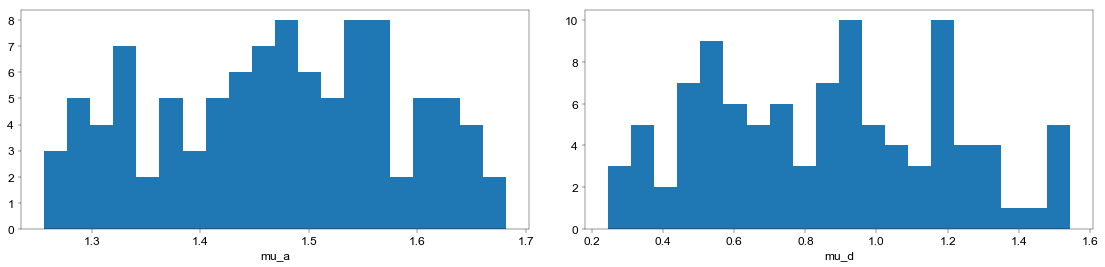

In [4]:
seed = 20170530
rej = elfi.Rejection(d,batch_size=10,seed=seed) 
result = rej.sample(100, quantile=0.01) 
result.summary()
result.plot_marginals();

In [7]:
# save samples selected
data=pd.DataFrame()
data['mu_a'] = result.samples['mu_a']
data['mu_d'] = result.samples['mu_d']
print(data.head())
data.to_csv('S7parafit.csv')

       mu_a      mu_d
0  1.494929  0.594672
1  1.501401  0.618684
2  1.498663  0.528282
3  1.429152  0.578477
4  1.435725  0.671028


In [15]:
def update_mbeta_s7(ms_est, beta_est, alpha, kappa, num_encounter, signal_mean=0):
	betac1 = (alpha-1)/(alpha-0.5)
	betac2 = 0.5*kappa*(alpha-1)/(kappa+1)/(alpha-0.5)
	for nstep in range(num_encounter):
		xs = np.random.normal(signal_mean, 1, size=(n_cells))  # gauss(mean,std)
		ms_new = (kappa*ms_est+xs)/(kappa+1)
		betas_new = betac1*beta_est + betac2*(xs-ms_est)**2
		ms_est = ms_new
		beta_est = betas_new
	return(ms_est, beta_est)


# Calculate the probability of activation
def POA_s7(alpha, kappa, ms_est, beta_est, u_target, env_mean=0):
	n_updates = 150
	n_cells = len(ms_est)
	theta = 0.01
	betac1 = (alpha-1)/(alpha-0.5)
	betac2 = 0.5*kappa*(alpha-1)/(kappa+1)/(alpha-0.5)
	poa_mean = []
	for i in range(n_updates):
		thresholds = t.ppf(1-theta, 2*alpha, ms_est, np.sqrt((kappa+1)*beta_est/kappa/alpha))
		poa = 1-norm.cdf(thresholds, loc=u_target, scale=1)
		poa_mean.append(np.mean(poa))
		# update
		xs = np.random.normal(env_mean,1,size=(n_cells) )
		ms_new = (kappa*ms_est+xs)/(kappa+1)
		betas_new = betac1*beta_est + betac2*(xs-ms_est)**2
		ms_est = ms_new
		beta_est = betas_new
	return(poa_mean)

mu_a = 1.49 
mu_d = 0.59 
# constants
alpha = 10
kappa = 2*alpha
#initial encounters
num_encounter = 50*alpha
n_cells = 1000

# blue line N(0,1)
ms_est = np.zeros(n_cells)
beta_est = np.ones(n_cells)*(alpha-1)
ms_est, beta_est = update_mbeta_s7(ms_est, beta_est, alpha, kappa, num_encounter) 
poa_mean_blue = POA_s7(alpha, kappa, ms_est, beta_est, mu_a)

# green line N(mu_d, 1)
ms_est = np.zeros(n_cells)
beta_est = np.ones(n_cells)*(alpha-1)
ms_est, beta_est = update_mbeta_s7(ms_est, beta_est, alpha, kappa, num_encounter, signal_mean=mu_d) 
poa_mean_green = POA_s7(alpha, kappa, ms_est, beta_est, mu_a, env_mean=mu_d)

# black line
ms_est = np.zeros(n_cells)
beta_est = np.ones(n_cells)*(alpha-1)
ms_est, beta_est = update_mbeta_s7(ms_est, beta_est, alpha, kappa, num_encounter, signal_mean=mu_d) 
poa_mean_black = POA_s7(alpha, kappa, ms_est, beta_est, mu_a)

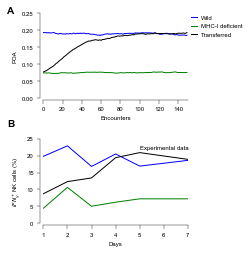

In [16]:
# plot adaptation
fig = plt.figure(figsize=(SINGLE_COLUMN, SINGLE_COLUMN))
plt.rc('font', size=LABEL_SIZE, family=FAMILY)
ax1 = fig.add_axes([0.15, 0.62, 0.6, 0.35])
ax2 = fig.add_axes([0.15, 0.1, 0.6, 0.35])
ax1.text(-0.25, 1.0, string.ascii_uppercase[0].upper(),
         transform=ax1.transAxes, size=SUBLABEL_SIZE, weight='bold')
ax2.text(-0.25, 1.15, string.ascii_uppercase[1].upper(),
         transform=ax2.transAxes, size=SUBLABEL_SIZE, weight='bold')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_position(('axes', -0.02))
ax1.spines['left'].set_position(('axes', -0.02))
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_position(('axes', -0.02))
ax2.spines['left'].set_position(('axes', -0.02))


ax1.plot(poa_mean_blue,c='blue',label='Wild')
ax1.plot(poa_mean_green,c='green',label='MHC-I deficient')
ax1.plot(poa_mean_black,c='black',label = 'Transferred')
ax1.set_xlim([0,150])
ax1.set_ylim([0,0.25])
ax1.set_xlabel('Encounters')
ax1.set_ylabel('POA')
ax1.legend(loc='center',bbox_to_anchor=(1.15, 0.6, 0.1, 0.5),handlelength=1, frameon=False)


x=[1,2,3,4,5,7]
exp_blue = [19.8, 22.9, 16.8, 20.5, 16.9, 18.6]
exp_black = [8.7, 12.3, 13.4, 19.4, 20.9, 18.9]
exp_green = [4.4, 10.6, 5, 6.2, 7.2, 7.2]
ax2.text(5,22,'Experimental data')
ax2.plot(x,exp_blue,c='blue',label='Wild')
ax2.plot(x,exp_green,c='green',label='MHC-I deficient')
ax2.plot(x,exp_black,c='black',label = 'Transferred')
ax2.set_xlim([1,7])
ax2.set_ylim([0,25])
ax2.set_xlabel('Days')
ax2.set_ylabel(r'$IFN_{\gamma}^{+}$ NK cells (%)')
#ax2.legend(loc='center',bbox_to_anchor=(0.85, 0.75, 0.1, 0.5),handlelength=1, frameon=False)


plt.savefig('figs7-adaption2envs.pdf', format='pdf', dpi=300)
plt.show()


## Figure Srpan exp data

In [3]:

def sim_experiment(alpha,mu_R, mu_M, N_nk, batch_size):
	kappa = 2*alpha
	ms=np.zeros((batch_size,N_nk))
	betas=np.ones((batch_size,N_nk))*alpha
	N_train = 300 # to ensure parameters adapt to healthy env
	for i in range(N_train):
		xs = np.random.randn(batch_size,N_nk)
		# mu_env and sigma_env .size=betch_size, xs[i,:]~N(mu[i],si[i])
		ms_new = (kappa*ms+xs)/(kappa+1)
		betas = (alpha-1)/(alpha-0.5)*(betas+0.5*kappa/(kappa+1)*(xs-ms)**2)
		ms = ms_new
		thresholds = t.ppf(0.99, 2*alpha, ms, np.sqrt((kappa+1)*betas/kappa/alpha))
	# interact with RR MM
	response = np.zeros((batch_size,N_nk,4))
	# RR
	xs = np.random.normal(mu_R, 1,size=((batch_size,N_nk)))
	response[:,:,0] = xs > thresholds
	ms_new_rr = (kappa*ms+xs)/(kappa+1)
	betas_rr = (alpha-1)/(alpha-0.5)*(betas+0.5*kappa/(kappa+1)*(xs-ms)**2)
	ms_rr = ms_new_rr
	thresholds_rr = t.ppf(0.99, 2*alpha, ms_rr, np.sqrt((kappa+1)*betas_rr/kappa/alpha))
	xs = np.random.normal(mu_R, 1,size=((batch_size,N_nk)))
	response[:,:,1] = xs > thresholds_rr
	# MM
	xs = np.random.normal(mu_M, 1,size=((batch_size,N_nk)))
	response[:,:,2] = xs > thresholds
	ms_new_MM = (kappa*ms+xs)/(kappa+1)
	betas_MM = (alpha-1)/(alpha-0.5)*(betas+0.5*kappa/(kappa+1)*(xs-ms)**2)
	ms_MM = ms_new_MM
	thresholds_MM = t.ppf(0.99, 2*alpha, ms_MM, np.sqrt((kappa+1)*betas_MM/kappa/alpha))
	xs = np.random.normal(mu_M, 1,size=((batch_size,N_nk)))
	response[:,:,3] = xs > thresholds_MM
	# cal 00,01,10,11
	result = np.zeros((batch_size,8))
	RR00 = (response[:,:,0]==0)*(response[:,:,1]==0)
	RR10 = (response[:,:,0]==1)*(response[:,:,1]==0)
	RR01 = (response[:,:,0]==0)*(response[:,:,1]==1)
	RR11 = (response[:,:,0]==1)*(response[:,:,1]==1)
	result[:,0] = np.sum(RR00,axis=1)/N_nk
	result[:,1] = np.sum(RR10,axis=1)/N_nk 
	result[:,2] = np.sum(RR01,axis=1)/N_nk
	result[:,3] = np.sum(RR11,axis=1)/N_nk
	MM00 = (response[:,:,2]==0)*(response[:,:,3]==0)
	MM10 = (response[:,:,2]==1)*(response[:,:,3]==0)
	MM01 = (response[:,:,2]==0)*(response[:,:,3]==1)
	MM11 = (response[:,:,2]==1)*(response[:,:,3]==1)
	result[:,4] = np.sum(MM00,axis=1)/N_nk
	result[:,5] = np.sum(MM10,axis=1)/N_nk 
	result[:,6] = np.sum(MM01,axis=1)/N_nk
	result[:,7] = np.sum(MM11,axis=1)/N_nk
	return(result)

def simulator(alpha, mu_R, mu_M, batch_size=10, random_state=None):
	alpha   = np.array(alpha).reshape((-1,1))
	mu_R    = np.array(mu_R).reshape((-1,1))
	mu_M    = np.array(mu_M).reshape((-1,1))
	N_nk    = 500
	res     = sim_experiment(alpha, mu_R, mu_M, N_nk, batch_size)
	return(res)

[[0.345 0.285 0.18  0.19  0.1   0.285 0.055 0.56 ]]


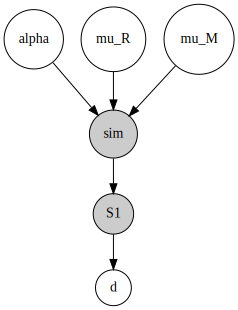

In [4]:
# observations
#exp_rr = [0.345, 0.285, 0.18, 0.19]
#exp_mm = [0.1, 0.285, 0.055, 0.56]
#exp_rm = [0.16, 0.03, 0.44, 0.37]
total = [[0.345, 0.285, 0.18, 0.19, 0.1, 0.285, 0.055, 0.56]]
y_exp = np.array(total)
print(y_exp)

# setting priot
alpha    = elfi.Prior('uniform',1,50)
mu_R     = elfi.Prior('gamma', 2, 0, 2)
mu_M     = elfi.Prior('gamma', 2, 0, 2)

sim = elfi.Simulator(simulator, alpha, mu_R, mu_M, observed=y_exp)

def feature(x): 
	return(x)

def distance(res_sim,res_obs):
	return(np.sum((res_sim-res_obs)**2,axis=1))
S1 = elfi.Summary(feature, sim)
d = elfi.Distance(distance, S1) # d btw summary and observe
elfi.draw(d) 

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Method: Rejection
Number of samples: 100
Number of simulations: 10000
Threshold: 0.0483
Sample means: alpha: 25.3, mu_M: 3.34, mu_R: 2.27


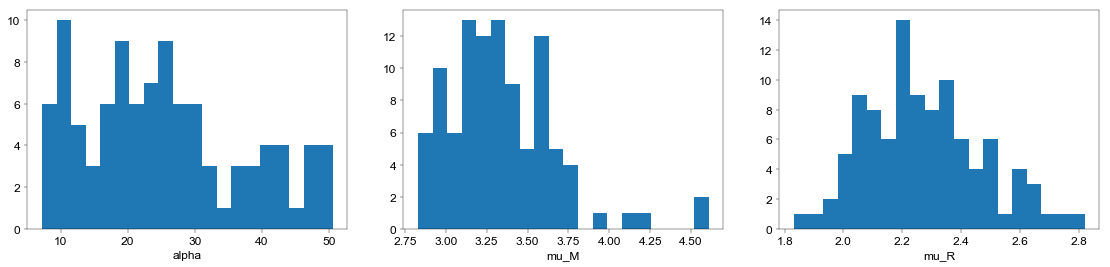

In [5]:
seed = 20210701
rej = elfi.Rejection(d,batch_size=1,seed=seed) 
result = rej.sample(100, quantile=0.01) 
#result = rej.sample(1, threshold=0.014) 
result.summary()
result.plot_marginals();

In [7]:
# save samples selected
data=pd.DataFrame()
data['alpha']   = result.samples['alpha']
data['mu_R']    = result.samples['mu_R']
data['mu_M']    = result.samples['mu_M']
print(data.head())
data.to_csv('S8parafit_rrmm.csv')

       alpha      mu_R      mu_M
0  21.448696  2.203821  3.224451
1  23.915558  2.302677  3.217432
2  16.798825  2.358604  3.398039
3  10.307480  2.414451  3.763003
4  20.278209  2.117117  3.220221


In [20]:
# simulate rr mm rm mr using the best fit, 1st row in save file
def killing(alpha,kappa,n_cells,ms_est,beta_est, mu_1, mu_2):
	betac1 = (alpha-1)/(alpha-0.5)
	betac2 = 0.5*kappa*(alpha-1)/(kappa+1)/(alpha-0.5)
	res = np.zeros((n_cells,2))
	xs = np.random.normal(mu_1,1,size=(n_cells))
	thresholds = t.ppf(0.99, 2*alpha, ms_est, np.sqrt((kappa+1)*beta_est/kappa/alpha))
	res[:,0] = thresholds < xs
	ms_new = (kappa*ms_est+xs)/(kappa+1)
	betas_new = betac1*beta_est + betac2*(xs-ms_est)**2
	xs = np.random.normal(mu_2,1,size=(n_cells))
	thresholds = t.ppf(0.99, 2*alpha, ms_new, np.sqrt((kappa+1)*betas_new/kappa/alpha))
	res[:,1] = thresholds < xs
	# stat
	rr00=np.sum((res[:,0]==0)*(res[:,1]==0))/n_cells*100
	rr10=np.sum((res[:,0]==1)*(res[:,1]==0))/n_cells*100
	rr01=np.sum((res[:,0]==0)*(res[:,1]==1))/n_cells*100
	rr11=np.sum((res[:,0]==1)*(res[:,1]==1))/n_cells*100
	rr = np.array([rr00,rr10,rr01,rr11])
	return(rr)
data = pd.read_csv('data/S8parafit_rrmm.csv')
alpha = data['alpha'][0]
mu_R = data['mu_R'][0]
mu_M = data['mu_M'][0]
kappa = 2*alpha
num_encounter = int(50*alpha)
n_cells = 2000
# train
ms_est = np.zeros(n_cells)
beta_est = np.ones(n_cells)*(alpha-1)
betac1 = (alpha-1)/(alpha-0.5)
betac2 = 0.5*kappa*(alpha-1)/(kappa+1)/(alpha-0.5)
for nstep in range(num_encounter):
	xs = np.random.randn(n_cells)  
	ms_new = (kappa*ms_est+xs)/(kappa+1)
	beta_est = betac1*beta_est + betac2*(xs-ms_est)**2
	ms_est = ms_new
# test
rr = killing(alpha,kappa,n_cells,ms_est,beta_est, mu_R, mu_R)
rm = killing(alpha,kappa,n_cells,ms_est,beta_est, mu_R, mu_M)
mm = killing(alpha,kappa,n_cells,ms_est,beta_est, mu_M, mu_M)
mr = killing(alpha,kappa,n_cells,ms_est,beta_est, mu_M, mu_R)
print(rr,mm,rm,mr)
print(alpha, mu_R, mu_M)

[32.45 28.65 23.6  15.3 ] [ 5.65 25.8  14.   54.55] [12.95 13.   43.75 30.3 ] [12.35 56.8   7.9  22.95]
21.44869627718901 2.20382067000127 3.224450882281438


In [21]:
# constant probability of activating # RR MM RM MR
exp_rr = np.array([0.345, 0.285, 0.18, 0.19])
exp_mm = np.array([0.1, 0.285, 0.055, 0.56])
exp_rm = np.array([0.16, 0.03, 0.44, 0.37])
exp_mr = np.array([0.18, 0.71, 0.05, 0.06])
from scipy.optimize import fmin
def likelihd(ps,exp_rr,exp_rm,exp_mr,exp_mm):
	p_R, p_M = ps
	p_rr = np.array([(1-p_R)**2, p_R*(1-p_R), (1-p_R)*p_R, p_R*p_R]) # 00 10 01 11
	p_mm = np.array([(1-p_M)**2, p_M*(1-p_M), (1-p_M)*p_M, p_M*p_M])
	p_rm = np.array([(1-p_R)*(1-p_M), p_R*(1-p_M), (1-p_R)*p_M, p_R*p_M])
	p_mr = np.array([(1-p_M)*(1-p_R), p_M*(1-p_R), (1-p_M)*p_R, p_M*p_R])
	y = np.sum((p_rr-exp_rr)**2)+np.sum((p_rm-exp_rm)**2)+np.sum((p_mr-exp_mr)**2)+np.sum((p_mm-exp_mm)**2)
	return(y)
initialguess = [0.5,0.5]
p_R,p_M = fmin(likelihd,initialguess,args=(exp_rr,exp_rm,exp_mr,exp_mm))
print(p_R,p_M)
Null_rr = np.array([(1-p_R)**2, (1-p_R)*p_R, (1-p_R)*p_R, p_R**2])*100
Null_mm = np.array([(1-p_M)**2, (1-p_M)*p_M, (1-p_M)*p_M, p_M**2])*100
Null_rm = np.array([(1-p_R)*(1-p_M), p_R*(1-p_M), (1-p_R)*p_M, p_R*p_M])*100
Null_mr = np.array([(1-p_M)*(1-p_R), p_M*(1-p_R), (1-p_M)*p_R, p_M*p_R])*100

Optimization terminated successfully.
         Current function value: 0.150886
         Iterations: 33
         Function evaluations: 65
0.3349381344800342 0.7685835387528654


In [22]:
exp_rr = np.array([0.345, 0.285, 0.18, 0.19])*100
exp_mm = np.array([0.1, 0.285, 0.055, 0.56])*100
exp_rm = np.array([0.16, 0.03, 0.44, 0.37])*100
exp_mr = np.array([0.18, 0.71, 0.05, 0.06])*100
print( np.sum((Null_rr-exp_rr)**2)+np.sum((Null_mm-exp_mm)**2)+
	  np.sum((Null_rm-exp_rm)**2)+np.sum((Null_mr-exp_mr)**2))
print( np.sum((rr-exp_rr)**2)+np.sum((mm-exp_mm)**2)+
	  np.sum((rm-exp_rm)**2)+np.sum((mr-exp_mr)**2))

1508.8575251297164
833.3700000000001


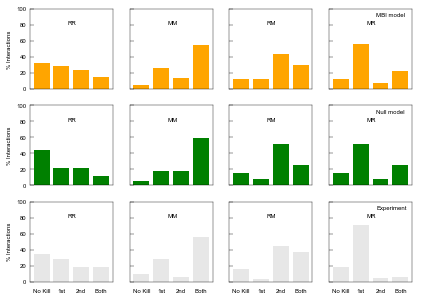

In [23]:
fig,axs = plt.subplots(3,4,sharey=True,figsize=(DOUBLE_COLUMN, SINGLE_COLUMN*1.5))
plt.rc('font', size=LABEL_SIZE, family=FAMILY)

for i in range(3):
	for j in range(4):
		axs[i,j].tick_params(axis='y',direction="in")
		axs[i,j].tick_params(axis='x',bottom=False)
for j in range(4):
	axs[0,j].tick_params(axis='x',labelbottom=False)
	axs[1,j].tick_params(axis='x',labelbottom=False)
	axs[2,j].tick_params(axis='x',labelsize = LABEL_SIZE)
for i in range(3):
	axs[i,0].tick_params(axis='y',labelsize = LABEL_SIZE)
	# plot simulation result
xlabels = ['No Kill', '1st', '2nd', 'Both']
axs[0,0].bar(xlabels,rr, color='orange')
axs[0,1].bar(xlabels,mm, color='orange')
axs[0,2].bar(xlabels,rm, color='orange')
axs[0,3].bar(xlabels,mr, color='orange')
plt.ylim([0,100])
axs[0,0].text(1.3,80,'RR')
axs[0,1].text(1.3,80,'MM')
axs[0,2].text(1.3,80,'RM')
axs[0,3].text(1.3,80,'MR')
axs[0,0].set_ylabel('% Interactions',fontsize=LABEL_SIZE)
axs[0,3].text(1.8,90,'MBI model')
# plot null model result
axs[1,0].bar(xlabels,Null_rr, color='green')
axs[1,1].bar(xlabels,Null_mm, color='green')
axs[1,2].bar(xlabels,Null_rm, color='green')
axs[1,3].bar(xlabels,Null_mr, color='green')
plt.ylim([0,100])
axs[1,0].text(1.3,80,'RR')
axs[1,1].text(1.3,80,'MM')
axs[1,2].text(1.3,80,'RM')
axs[1,3].text(1.3,80,'MR')
axs[1,0].set_ylabel('% Interactions',fontsize=LABEL_SIZE)
axs[1,3].text(1.8,90,'Null model')

# plot experimental result
exp_rr = [0.345, 0.285, 0.18, 0.19]
exp_mm = [0.1, 0.285, 0.055, 0.56]
exp_rm = [0.16, 0.03, 0.44, 0.37]
exp_mr = [0.18, 0.71, 0.05, 0.06]
exp_rr = np.array(exp_rr)*100
exp_mm = np.array(exp_mm)*100
exp_rm = np.array(exp_rm)*100
exp_mr = np.array(exp_mr)*100
axs[2,0].bar(xlabels,exp_rr,color=(0.1, 0.1, 0.1, 0.1))
axs[2,1].bar(xlabels,exp_mm,color=(0.1, 0.1, 0.1, 0.1))
axs[2,2].bar(xlabels,exp_rm,color=(0.1, 0.1, 0.1, 0.1))
axs[2,3].bar(xlabels,exp_mr,color=(0.1, 0.1, 0.1, 0.1))
axs[2,0].text(1.3,80,'RR')
axs[2,1].text(1.3,80,'MM')
axs[2,2].text(1.3,80,'RM')
axs[2,3].text(1.3,80,'MR')
axs[2,3].text(1.8,90,'Experiment')
axs[2,0].set_ylabel('% Interactions',fontsize=LABEL_SIZE)

plt.savefig('figs8-2targetskilling.pdf',format='pdf', dpi=300)
plt.show()